In [345]:
import numpy as np
from scipy.linalg import expm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

# Parâmetros Globais

**Cada vez que mudar os parâmetros, rodar todo o notebook novamente.**

In [346]:
beta = 1.2
gamma = 0.8
epsilon = 0
alpha = 0
n = 420     #População total
max_t = 50
initial_infected = 50

# Cadeia de Markov

In [347]:
Q = np.zeros([n+1, n+1])

for i in range(n+1):
  for j in range(n+1):
    b = beta*i*(n-i)/n + epsilon*(n-i)
    d = gamma*i        + alpha*(n-i)*i/n
    if j==i-1:
      Q[i,j]=d
    elif j==i+1:
      Q[i,j]=b
    elif j==i:
      Q[i,j]=-(b+d)

[50, 63.293719724673096, 76.76063601765912, 89.41361002940948, 100.54283618525683, 109.80930642657633, 117.19241391151024, 122.87511118058099, 127.13363705606845, 130.26020512061757, 132.52018732837504, 134.13459536133786, 135.27761133398405, 136.08147444896406, 136.64398566443376, 137.0361337385986, 137.30875103282557, 137.4978775222614, 137.62888011702412, 137.7195180264375, 137.7821753388504, 137.8254627606207, 137.8553544908478, 137.87598892374328, 137.89022942141204, 137.90005544306018, 137.90683453313267, 137.911511042781, 137.9147368656673, 137.91696189570132, 137.91849656260948, 137.91955503584666, 137.9202850585828, 137.92078854310475, 137.9211357841075, 137.9213752656854, 137.92154042791017, 137.92165433404355, 137.92173289070263, 137.9217870679344, 137.92182443151003, 137.92185019971214, 137.92186797079273, 137.92188022679102, 137.92188867915016, 137.9218945083165, 137.92189852849668, 137.9219013009717, 137.92190321310815, 137.9219045317672]


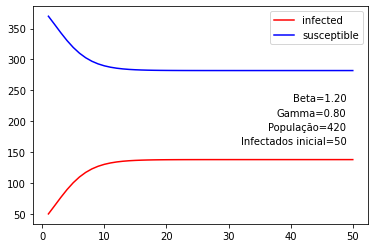

In [348]:
def meanLoop(Q, max_t, n, t=0, initial_infected=1, infected=1, history=[], times=[]):
  history.append(infected)
  times.append(t)
  if t>=max_t:
    return (history, times)
  # P(t) = e^{tQ}
  # A função de transição P(t) é usada para calcular o valor esperado de X_t
  P = expm(t*Q)

  # E(X_t|X_{t-1}=i) = sum{ j*P(X_t=j|X_{t-1}=i) }
  # Aqui, arrendondamos o número atual de infectados (i) porque não existe uma pessoal parcialmente infectada
  terms = [j * P[initial_infected,j] for j in range(n+1)]
  expected_value = sum(terms)

  # Usamos o valor esperado calculado para calcular para t+1
  return meanLoop(Q, max_t, n, t+1, initial_infected, expected_value, history, times)

(history, times) = meanLoop(Q, max_t, n, t=1, initial_infected=initial_infected, infected=initial_infected, history=[])

print(history)
susceptible=[n-i for i in history]

plt.plot(times, history, 'r', label='infected')
plt.plot(times, susceptible, 'b', label='susceptible')
plt.legend()

plt.figtext(0.85, 0.55, "Beta=%.2f" % (beta), ha="right")
plt.figtext(0.85, 0.5, "Gamma=%.2f" % (gamma), ha="right")
plt.figtext(0.85, 0.45, "População=%d" % (n), ha="right")
plt.figtext(0.85, 0.4, "Infectados inicial=%d" % (initial_infected), ha="right")
plt.show()

# EDO

In [349]:
# constants
INITIAL_POPULATION: int = n  # initial population
BETA: float = beta  # infection rate
GAMMA: float = gamma  # recovery rate

MI_0: float = alpha  # transmission of good news
LAMBDA_1: float = epsilon  # exogenous infection rate

INITIAL_INFECTED: int = initial_infected
INITIAL_SUSCEPTIBLE: int = INITIAL_POPULATION - INITIAL_INFECTED
TIME_GRID = np.linspace(start=0, stop=max_t, num=max_t)

In [350]:
# The SIS model differential equations
def derivative(system_condition, t):
    susceptible, infected = system_condition
    susceptible_dif_derivative: float = (-BETA * susceptible * infected / INITIAL_POPULATION) + (
            GAMMA * infected)  # derivative of S(t)
    infected_dif_derivative: float = (BETA * susceptible * infected / INITIAL_POPULATION) - (
            GAMMA * infected)  # derivative of I(t)

    return [susceptible_dif_derivative, infected_dif_derivative]

In [351]:
def simple_ode_solution():
    initial_condition: list[int] = [INITIAL_SUSCEPTIBLE, INITIAL_INFECTED]

    # Integrate the SIS equations over the time grid .
    y = odeint(derivative, initial_condition, TIME_GRID)

    susceptible = y[:, 0]
    infected = y[:, 1]

    return [susceptible, infected]

# Simulação de Eventos

In [352]:
import queue
from dataclasses import dataclass, field

@dataclass(order=True)
class Event:
  time: float
  event_type: str=field(compare=False)

In [353]:
def generate_infection(t, rate, infected, population):
    susceptible = population - infected
    beta_i = rate * infected * susceptible / population
    infection_time = np.random.exponential(1/beta_i) 
    infection_event = Event(t + infection_time, 'infection')
    return infection_event

def generate_cure(t, rate, infected):
    gamma_i = rate * infected
    cure_time = np.random.exponential(1/gamma_i) 
    cure_event = Event(t + cure_time, 'cure')
    return cure_event

def initialize_queue(initial_beta, initial_gamma, total_population, initial_infected):
  q = queue.PriorityQueue()

  for i in range(initial_infected):
    q.put(generate_cure(0, initial_gamma, initial_infected))
    q.put(generate_infection(0, initial_beta, initial_infected, total_population))
  
  return q

In [354]:
def simulate_epidemic(initial_beta, initial_gamma, total_population, initial_infected, max_time):
  q = initialize_queue(initial_beta, initial_gamma, total_population, initial_infected)
  curr_infected = initial_infected
  curr_time = 0
  times = []
  amount_infected = []

  # 2 elementos:
  # cura
  # infecção <-

  while not q.empty(): 
    e = q.get() # Event(time=float, event_type=enum('cure', 'infection'))
    curr_time = e.time
    
    # se tem 0 infectados ou passou o tempo, retorna
    if curr_infected == 0 or e.time > max_time: 
      return times, amount_infected
    elif e.event_type == 'infection' and curr_infected < total_population:
      # Aqui sabemos que, caso toda a população esteja infectada, 
      # não é mais agendado evento de infecção
      curr_infected += 1
      q.put(generate_infection(curr_time, initial_beta, curr_infected, total_population))
    elif e.event_type == 'cure':
      # Quando infectamos a população inteira, além da cura, também geramos
      # Um novo evento de infecção é gerado SE o evento de infecção acima não estiver agendado
      if curr_infected == total_population and q.empty():
        q.put(generate_infection(curr_time, initial_beta, curr_infected - 1, total_population))
      curr_infected -= 1
      q.put(generate_cure(curr_time, initial_gamma, curr_infected))

    times.append(e.time)
    amount_infected.append(curr_infected)

  return times, amount_infected

In [355]:
total_population = n
max_time = max_t
num_simulations = 1

# Juntando Todos

In [356]:
def plot(system_condition, markovResult):
    susceptible, infected = system_condition    
    markovSusceptible=[n-i for i in history]
    total_infected_stationary = []

    fig = plt.gcf()
    fig.set_size_inches(15, 7)

    for i in range(5):
      times, eventResult = simulate_epidemic(beta/initial_infected, gamma/initial_infected, total_population, initial_infected, max_time)
      amount_susceptible = n - np.array(eventResult)
      newTimes = np.array(times)

      total_infected_stationary += amount_infected[5000:]

      if i == 0:
        plt.plot(newTimes, amount_susceptible, color='mediumturquoise', label="S(t) - Eventos", linewidth=0.7)
        plt.plot(newTimes, eventResult, color='lightsalmon', label="I(t) - Eventos", linewidth=0.7)  
      else:
        plt.plot(newTimes, amount_susceptible, color='mediumturquoise', linewidth=0.7)
        plt.plot(newTimes, eventResult, color='lightsalmon', linewidth=0.7)

    plt.plot(TIME_GRID, susceptible, color='darkcyan', label="S(t) - EDO", linewidth=1.1)
    plt.plot(TIME_GRID, infected, color='magenta', label="I(t) - EDO", linewidth=1.1)
  
    plt.plot(TIME_GRID, markovSusceptible, '--', color='darkblue', label="S(t) - Markov")
    plt.plot(TIME_GRID, markovResult, '--',color='darkred', label="I(t) - Markov")

    plt.legend()

    plt.figtext(0.85, -0.15, "Beta=%.2f" % (beta), ha="right")
    plt.figtext(0.85, -0.1, "Gamma=%.2f" % (gamma), ha="right")
    plt.figtext(0.85, -0.05, "População=%d" % (n), ha="right")
    plt.figtext(0.85, 0, "Infectados inicial=%d" % (initial_infected), ha="right")

    sample_avg = np.average(total_infected_stationary)
    sample_std = np.std(total_infected_stationary)
    n_samples = len(total_infected_stationary)
    dec = 2
    ls = sample_avg + 1.96 * sample_std / (n_samples)**(1/2) 
    li = sample_avg - 1.96 * sample_std / (n_samples)**(1/2)
    plt.figtext(0.15, 0, "Média=%.2f" % (round(sample_avg, dec)), ha="left")
    plt.figtext(0.15, -0.05, "Desvio padrão=%.2f" % (round(sample_std, dec)), ha="left")
    plt.figtext(0.15, -0.1, f"Intervalo de confiança (95%): ({round(li, dec)}, {round(ls, dec)})", ha="left")

    plt.show()

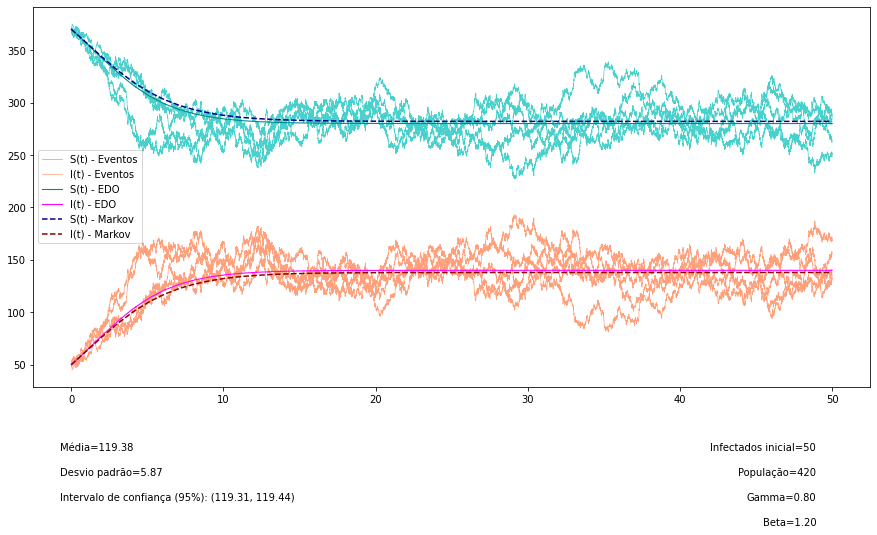

In [357]:
(history, times) = meanLoop(Q, max_t, n, t=1, initial_infected=initial_infected, infected=initial_infected, history=[])

# times, eventResult = simulate_epidemic(beta/10, gamma/10, total_population, initial_infected, max_time)
# newTimes = np.array(times)
# amount_susceptible = total_population - np.array(history)

plot(simple_ode_solution(), history)